## Notes, resources, other...

In [146]:
'''
https://stackoverflow.com/questions/22219004/grouping-rows-in-list-in-pandas-groupby

# below creates unique set of keys comprised of first 4 columns (C/A, STATION, UNIT, etc.)
new_set = set(zip(df['C/A'], df['UNIT'], df['SCP'], df['STATION']))

# below works as an initial groupby consolidation
df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE']).count()



OBJECTIVES / DELIVERABLES:
- could suggest when to host the event based on what part of year we can reach most attendees
'''

"\nhttps://stackoverflow.com/questions/22219004/grouping-rows-in-list-in-pandas-groupby\n\n# below creates unique set of keys comprised of first 4 columns (C/A, STATION, UNIT, etc.)\nnew_set = set(zip(df['C/A'], df['UNIT'], df['SCP'], df['STATION']))\n\n# below works as an initial groupby consolidation\ndf.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE']).count()\n\n\n\nOBJECTIVES / DELIVERABLES:\n- could suggest when to host the event based on what part of year we can reach most attendees\n"

### Read files into df

In [147]:
import pandas as pd
# list of .txt files to be read
txt_docs_list = ['turnstile_160409.txt', 'turnstile_180310.txt', 'turnstile_180317.txt',
                 'turnstile_180324.txt', 'turnstile_180331.txt', 'turnstile_180407.txt']

# reading in the files
df_list = []
for each in range(5):
    df_list.append(pd.read_csv(txt_docs_list[each]))

# concatenating the DFs together as 'df'
df = pd.concat(df_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982772 entries, 0 to 196653
Data columns (total 11 columns):
C/A                                                                     982772 non-null object
UNIT                                                                    982772 non-null object
SCP                                                                     982772 non-null object
STATION                                                                 982772 non-null object
LINENAME                                                                982772 non-null object
DIVISION                                                                982772 non-null object
DATE                                                                    982772 non-null object
TIME                                                                    982772 non-null object
DESC                                                                    982772 non-null object
ENTRIES                           

### clean up formatting of data
- strip, astype, other???

In [148]:
# Strip column headings
df.columns = df.columns.str.strip()
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

### create 'turnstile' - unique column for counting entries / exits
 - could use groupby
 - could avoid groupby, then sort by dates, then build list for unique vals in each date...
 - could use groupby then .apply(list) to compress the values down into a list entry in a new column <-- Yes

In [149]:
# Concat first four rows (rather than groupby) as unique ID for turnstile
df['turnstile_id'] = df['C/A'] + '_' + df['UNIT'] + '_' + df['SCP'] + '_' + df['STATION']

In [150]:
# Convert data types to reduce file size
df['C/A'] = df['C/A'].astype('category')
df['DIVISION'] = df['DIVISION'].astype('category')
df['UNIT'] = df['UNIT'].astype('category')
df['ENTRIES'] = df['ENTRIES'].astype('int32')
df['EXITS'] = df['EXITS'].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982772 entries, 0 to 196653
Data columns (total 12 columns):
C/A             982772 non-null category
UNIT            982772 non-null category
SCP             982772 non-null object
STATION         982772 non-null object
LINENAME        982772 non-null object
DIVISION        982772 non-null category
DATE            982772 non-null object
TIME            982772 non-null object
DESC            982772 non-null object
ENTRIES         982772 non-null int32
EXITS           982772 non-null int32
turnstile_id    982772 non-null object
dtypes: category(3), int32(2), object(7)
memory usage: 72.2+ MB


## Datetime adjustments

In [151]:
# for later... https://stackoverflow.com/questions/24082784/pandas-dataframe-groupby-datetime-month
# below datetime column yet unused... find here later.
#df['datetime'] = df['DATE'] + ' ' + df['TIME']
#df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%Y %H:%M:%S')
df['date'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
#df.info() #confirm changes

## Build list for each count within day (list range method)
- will eventually need to break out for recorded interval, but start here
- after recorded interval, build out on hourly basis

In [152]:
# apply list of count recordings to values recorded within each day
entries_list = list(df.groupby(['turnstile_id', 'date'])['ENTRIES'].apply(list))
exits_list = list(df.groupby(['turnstile_id', 'date'])['EXITS'].apply(list))
#len(entries_list)

In [153]:
# below just to visualize
#type(df.groupby(['turnstile', 'DATE'])['ENTRIES'].apply(list))

## Build daily turnstile count (list range method)

In [154]:
# Use above lists ('entries_list' & 'exits_list') to generate single integer count value for each day
# Count value will not necessarilly be accurate due to roll-over counts
# Count value ALSO not accurate because if last measurement is 4 hours prior for subsequent day's first measurement,
## we will lose that data.
##### Below also could use custom aggregation (define function and use .agg(<function_name>) to get what we want)
'''
def entries_range(series):
    return(series.max() - series.min())
...then...
XXXXXXXX.groupby().agg(entries_range(entries_list))
'''
entries_count = []
for en in entries_list:
    entries_count.append(en[-1] - en[0])

exits_count = []
for ex in exits_list:
    exits_count.append(ex[-1] - ex[0])
    
#entries_count[:30000:300] # confirm it works...
#print(len(entries_count)) # confirm length
#print(len(exits_count))   # confirm length 


## Build DF of calculated turnstile counts and 'date'
- Eliminated 'datetime' and original 'DATE' and 'TIME' columns here. For future reference...

In [155]:
# now build the appropriate df from original data ('unit')
## separate df that returns only same # of rows as this series (basically agg'd by turnstile & DATE) (32,125 rows)

df_turnstile_counts = df.groupby(['turnstile_id', 'date']).count()
df_turnstile_counts.drop(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'TIME', 'DESC', 'ENTRIES', 'EXITS', 'DATE'], axis=1, inplace=True)
df_turnstile_counts['entries_list'] = entries_list
df_turnstile_counts['exits_list'] = exits_list
df_turnstile_counts['entries_count'] = entries_count
df_turnstile_counts['exits_count'] = exits_count
df_turnstile_counts['entries_exits'] = df_turnstile_counts['entries_count'] + df_turnstile_counts['exits_count']
df_turnstile_counts.reset_index(inplace=True)

df_turnstile_counts.head()

,turnstile_id,date,entries_list,exits_list,entries_count,exits_count,entries_exits
0,A002_R051_02-00-00_59 ST,2016-04-02,"[5600838, 5600863, 5600877, 5600922, 5601172, ...","[1896290, 1896293, 1896313, 1896375, 1896445, ...",646,234,880
1,A002_R051_02-00-00_59 ST,2016-04-03,"[5601621, 5601638, 5601643, 5601722, 5601917, ...","[1896558, 1896566, 1896578, 1896648, 1896718, ...",529,211,740
2,A002_R051_02-00-00_59 ST,2016-04-04,"[5602244, 5602256, 5602297, 5602326, 5602456, ...","[1896791, 1896793, 1896893, 1896945, 1897174, ...",1189,561,1750
3,A002_R051_02-00-00_59 ST,2016-04-05,"[5603671, 5603729, 5603886, 5604169, 5604944]","[1897387, 1897497, 1897817, 1897905, 1898006]",1273,619,1892
4,A002_R051_02-00-00_59 ST,2016-04-06,"[5605129, 5605137, 5605168, 5605278, 5605583, ...","[1898051, 1898054, 1898158, 1898357, 1898440, ...",1249,478,1727


## Create 'station' column around which to aggregate/group/summarize
- in order to: sum by station by week or month
- in order to: sum by station then day of week

In [156]:
# Create 'station' by slicing from 'turnstile'
df_turnstile_counts['station'] = df_turnstile_counts['turnstile_id'].str.slice(19)

# below confirms it works
for i in range(0,30000,3000):
    print('STATION NAME: ' + df_turnstile_counts.station[i], 'TURNSTILE NAME: ' + df_turnstile_counts.turnstile_id[i])
    

STATION NAME: 59 ST TURNSTILE NAME: A002_R051_02-00-00_59 ST
STATION NAME: 28 ST TURNSTILE NAME: A027_R082_01-00-00_28 ST
STATION NAME: CANAL ST TURNSTILE NAME: A046_R463_00-03-00_CANAL ST
STATION NAME: WHITEHALL S-FRY TURNSTILE NAME: A060_R001_00-00-07_WHITEHALL S-FRY
STATION NAME: CHURCH AV TURNSTILE NAME: B016_R098_00-00-00_CHURCH AV
STATION NAME: SHEEPSHEAD BAY TURNSTILE NAME: B027_R136_00-00-01_SHEEPSHEAD BAY
STATION NAME: PROSPECT AV TURNSTILE NAME: C014_R246_00-03-00_PROSPECT AV
STATION NAME: 20 AV TURNSTILE NAME: D009_R393_00-00-02_20 AV
STATION NAME: W 8 ST-AQUARIUM TURNSTILE NAME: G011_R312_00-00-03_W 8 ST-AQUARIUM
STATION NAME: DEKALB AV TURNSTILE NAME: H023_R236_00-06-01_DEKALB AV


In [157]:
# totals by station (but this is TOTALLLLLS of all data. Need to sum by week or day. 
# Thus, need datetime to define corresponding days of weeks
df_station_sum = df_turnstile_counts.groupby(['station', 'date'])[['entries_count','exits_count', 'entries_exits']].sum()
df_station_sum.head()

entries_count  exits_count  entries_exits
station date                                                 
1 AV    2016-04-02          15739        10625          26364
        2016-04-03          12836         8962          21798
        2016-04-04          19091        13968          33059
        2016-04-05          18673        12222          30895
        2016-04-06          21212        13427          34639

Why would above totals per day per station have much, if any, difference between entries and exits?

## Build daily turnstile count list (incorporating class's shift method)

In [158]:
#df_turnstile_counts.entries_list[0][0]

In [159]:
# Class shift process for getting the daily entries/exits
#turnstiles_daily = turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"]).ENTRIES.first().reset_index()

'''
        for x in df.entries_list:
    df3_first_entry_list = x
'''
df_turnstile_counts['first_entry'] = [x[0] for x in df_turnstile_counts.entries_list]
df_turnstile_counts['first_exit'] = [x[0] for x in df_turnstile_counts.exits_list]
#df_turnstile_counts.first_entry[2000]  # confirming it works

In [160]:
# Class shift process cont'd...
#turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       #.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       #.transform(lambda grp: grp.shift(1)))
df_turnstile_counts[["PREV_DATE", "PREV_ENTRIES"]] = (df_turnstile_counts
                                                       .groupby('turnstile_id')['date', 'first_entry']
                                                       .transform(lambda grp: grp.shift(1)))
df_turnstile_counts['PREV_EXITS'] = (df_turnstile_counts
                                                       .groupby('turnstile_id')['first_exit']
                                                       .transform(lambda grp: grp.shift(1)))

In [161]:
# Drop the NaN rows for last date
df_turnstile_counts.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

# summarize 
df_turnstile_counts['shift_entries'] = df_turnstile_counts['first_entry'] - df_turnstile_counts['PREV_ENTRIES']
df_turnstile_counts['shift_exits'] = df_turnstile_counts['first_exit'] - df_turnstile_counts['PREV_EXITS']
df_turnstile_counts.head()

,turnstile_id,date,entries_list,exits_list,entries_count,exits_count,entries_exits,station,first_entry,first_exit,PREV_DATE,PREV_ENTRIES,PREV_EXITS,shift_entries,shift_exits
1,A002_R051_02-00-00_59 ST,2016-04-03,"[5601621, 5601638, 5601643, 5601722, 5601917, ...","[1896558, 1896566, 1896578, 1896648, 1896718, ...",529,211,740,59 ST,5601621,1896558,2016-04-02,5600838.0,1896290.0,783.0,268.0
2,A002_R051_02-00-00_59 ST,2016-04-04,"[5602244, 5602256, 5602297, 5602326, 5602456, ...","[1896791, 1896793, 1896893, 1896945, 1897174, ...",1189,561,1750,59 ST,5602244,1896791,2016-04-03,5601621.0,1896558.0,623.0,233.0
3,A002_R051_02-00-00_59 ST,2016-04-05,"[5603671, 5603729, 5603886, 5604169, 5604944]","[1897387, 1897497, 1897817, 1897905, 1898006]",1273,619,1892,59 ST,5603671,1897387,2016-04-04,5602244.0,1896791.0,1427.0,596.0
4,A002_R051_02-00-00_59 ST,2016-04-06,"[5605129, 5605137, 5605168, 5605278, 5605583, ...","[1898051, 1898054, 1898158, 1898357, 1898440, ...",1249,478,1727,59 ST,5605129,1898051,2016-04-05,5603671.0,1897387.0,1458.0,664.0
5,A002_R051_02-00-00_59 ST,2016-04-07,"[5606603, 5606619, 5606656, 5606803, 5607108, ...","[1898562, 1898565, 1898680, 1898963, 1899032, ...",1265,583,1848,59 ST,5606603,1898562,2016-04-06,5605129.0,1898051.0,1474.0,511.0


## Final DFs summarized by Turnstile and by Station
#### Keep in mind the following:
- 'date' column type = datetime
- 'entries_count' and 'exits_count' are based on Jonathan's list range method
- 'shift_entries' and 'shift_exits' are based on the shift method presented in class

### Turnstile Summary

In [162]:
turnstile_df = df_turnstile_counts.drop(['entries_list', 'exits_list', 'first_entry', 'first_exit', 'PREV_ENTRIES', 'PREV_EXITS'], axis=1)
turnstile_df.head()

,turnstile_id,date,entries_count,exits_count,entries_exits,station,PREV_DATE,shift_entries,shift_exits
1,A002_R051_02-00-00_59 ST,2016-04-03,529,211,740,59 ST,2016-04-02,783.0,268.0
2,A002_R051_02-00-00_59 ST,2016-04-04,1189,561,1750,59 ST,2016-04-03,623.0,233.0
3,A002_R051_02-00-00_59 ST,2016-04-05,1273,619,1892,59 ST,2016-04-04,1427.0,596.0
4,A002_R051_02-00-00_59 ST,2016-04-06,1249,478,1727,59 ST,2016-04-05,1458.0,664.0
5,A002_R051_02-00-00_59 ST,2016-04-07,1265,583,1848,59 ST,2016-04-06,1474.0,511.0


### Station Summary

In [163]:
turnstile_df['station'] = turnstile_df['turnstile_id'].str.slice(19)
station_df = turnstile_df.groupby(['station', 'date'])[['entries_count','exits_count', 'entries_exits', 'shift_entries', 'shift_exits']].sum()
station_df.reset_index(inplace=True)
station_df.head()

,station,date,entries_count,exits_count,entries_exits,shift_entries,shift_exits
0,1 AV,2016-04-03,12836,8962,21798,20472.0,13691.0
1,1 AV,2016-04-04,19091,13968,33059,15547.0,10470.0
2,1 AV,2016-04-05,18673,12222,30895,22231.0,15732.0
3,1 AV,2016-04-06,21212,13427,34639,22369.0,14272.0
4,1 AV,2016-04-07,20852,13336,34188,25382.0,15420.0


# 2. Start the EDA & Plotting/Visualizing
#### How to confirm the counts are correct???
- option 1: eliminate row if list contains a 0 or counts through zero
- option 2: eliminate row if returns (-) value
- option 3: determine max count for the counters and look for values approaching max, this also requires confirming that max count is same across all turnstiles)
- option 4: identify the 'reset' value / max count within the list and work with it
- option 5: ...?

mean: 7330.709254139431
median: 733.0
std: 7489070.755480573


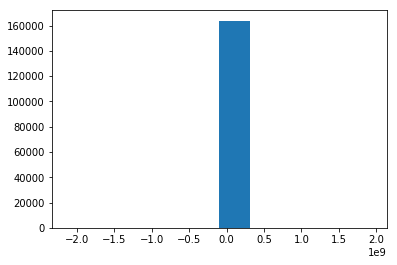

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

print('mean: ' + str(np.mean(entries_count)))
print('median: ' + str(np.median(entries_count)))
print('std: ' + str(np.std(entries_count)))

#below doesn't quite work, but keeping it close for reference...
'''
entries_dict = defaultdict(int)
for k in entries_count:
    entries_dict[k] += 1

    
pos = np.arange(len(entries_dict.keys()))
width = 1.0     # gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(entries_dict.keys())
    
plt.bar(list(entries_dict.keys()), entries_dict.values())
plt.show()
'''

plt.hist(entries_count)
plt.show()